In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from model.generator_cbam import AttnUNet
from model.discriminator import PixelDiscriminator
from pytorch_model_summary import summary
from dataset import *
from losses import *

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
batch_size = 16

train_path = 'data/trainset.npy'
valid_path = 'data/validset.npy'

train_set = npyDataset(npy_file=train_path, resize_h=256, resize_w=256)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

valid_set = npyDataset(npy_file=valid_path, resize_h=256, resize_w=256)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

dataiter = iter(train_set)
targets, inputs  = next(dataiter)
print(torch.min(targets), torch.max(targets))
print(inputs.shape)

tensor(-1.0480) tensor(3.7225)
torch.Size([1, 256, 256])


In [4]:
resolution = 256
in_channels = 1
out_channels = 1

def initialize_weights(m):
  if isinstance(m, nn.Conv2d):
      nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
      if m.bias is not None:
          nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.BatchNorm2d):
      nn.init.constant_(m.weight.data, 1)
      nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Linear):
      nn.init.kaiming_uniform_(m.weight.data)
      nn.init.constant_(m.bias.data, 0)

In [5]:
generator = AttnUNet(in_channels, out_channels).to(device)

x = torch.ones([batch_size, in_channels, resolution, resolution]).cuda()

print(summary(generator,x))
print('input:',x.shape)
print('output:',generator(x).shape)
print('===================================')

generator.apply(initialize_weights)

--------------------------------------------------------------------------
      Layer (type)           Output Shape         Param #     Tr. Param #
          inconv-1     [16, 32, 256, 256]           9,632           9,632
            down-2     [16, 64, 128, 128]          56,232          56,232
            down-3      [16, 128, 64, 64]         223,980         223,980
            down-4      [16, 256, 32, 32]         894,324         894,324
            down-5      [16, 512, 16, 16]       3,574,404       3,574,404
              up-6      [16, 256, 32, 32]       2,303,604       2,303,604
          Conv2d-7        [16, 1, 32, 32]              65              65
              up-8      [16, 128, 64, 64]         576,364         576,364
          Conv2d-9        [16, 1, 64, 64]              17              17
             up-10     [16, 64, 128, 128]         144,360         144,360
         Conv2d-11      [16, 1, 128, 128]               5               5
             up-12     [16, 32, 256, 

/home/sha/anaconda3/envs/dvaa/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


AttnUNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), paddi

In [6]:
discriminator = PixelDiscriminator(2).to(device)

x = torch.ones([batch_size, 2, resolution, resolution]).cuda()

print(summary(discriminator,x))
print('input:',x.shape)
print('output:',discriminator(x).shape)
print('===================================')

discriminator.apply(initialize_weights)

---------------------------------------------------------------------------
      Layer (type)            Output Shape         Param #     Tr. Param #
          Conv2d-1     [16, 128, 128, 128]           4,224           4,224
       LeakyReLU-2     [16, 128, 128, 128]               0               0
          Conv2d-3       [16, 256, 64, 64]         524,544         524,544
       LeakyReLU-4       [16, 256, 64, 64]               0               0
          Conv2d-5       [16, 512, 32, 32]       2,097,664       2,097,664
       LeakyReLU-6       [16, 512, 32, 32]               0               0
          Conv2d-7       [16, 512, 31, 31]       4,194,816       4,194,816
       LeakyReLU-8       [16, 512, 31, 31]               0               0
          Conv2d-9         [16, 1, 30, 30]           8,193           8,193
Total params: 6,829,441
Trainable params: 6,829,441
Non-trainable params: 0
---------------------------------------------------------------------------
input: torch.Size([16,

PixelDiscriminator(
  (conv1): Sequential(
    (0): Conv2d(2, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(512, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (out_conv): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [7]:
g_lr = 0.0002
d_lr = 0.00002

epochs = 200

# G loss
coefs = [1, 1, 1, 1, 0.05]
mse_loss_1 = Intensity_Loss().to(device)
mse_loss_2 = Intensity_Loss().to(device)
gd_loss_1 = Gradient_Loss(1).to(device)
gd_loss_2 = Gradient_Loss(1).to(device)
adv_loss = Adversarial_Loss().to(device)

# D loss
disc_loss = Discriminate_Loss().to(device)

optimizer_g = torch.optim.Adam(generator.parameters(), lr=g_lr)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=d_lr)

In [8]:
SAVE_PATH = './weight/attn_gan_generator'
BEST_SAVE_PATH = './weight/attn_gan_generator_best.pth'
LAST_SAVE_PATH = './weight/attn_gan_generator_last.pth'
train_g_losses = []
valid_g_losses = []
best_epoch = 0

In [9]:
def getG_loss(out, sub, out_target, sub_target, fake, coefs): 
    '''
    coefs = [1, 1, 1, 1, 0.05]
    '''

    mse_out = mse_loss_1(out, out_target)
    mse_sub = mse_loss_2(sub, sub_target)
    gdl_out = gd_loss_1(out, out_target)
    gdl_sub = gd_loss_2(sub, sub_target)
    adl = adv_loss(fake)

    loss_gen = coefs[0] * mse_out + \
               coefs[1] * mse_sub + \
               coefs[2] * gdl_out + \
               coefs[3] * gdl_sub + \
               coefs[4] * adl
    
    return loss_gen 

In [10]:
def getD_loss(real, fake):
    return disc_loss(real, fake)

In [11]:
# training
for epoch in range(epochs):
    train_sum_loss = 0
    val_sum_loss = 0  

    for i, data in enumerate(train_loader, 0):
        
        nd, qd = data
 
        input = qd.to(device) # qd = input

        target1 = (nd).to(device) # nd = target1
        target2 = (nd-qd).to(device) # difference map = target2
        target = torch.cat([target1, target2], dim=1)
 
        # train G
        out_g = generator(input) # predict nd 
        sub_g = out_g - input # predict diff map 
        pred = torch.cat([out_g, sub_g], dim=1).to(device)

        fake = discriminator(pred) # Fake [pred nd, pred diff] <for adv learning> 
        loss_gen = getG_loss(out=out_g, sub=sub_g, out_target=target1, sub_target=target2, fake=fake, coefs=coefs)

        optimizer_g.zero_grad()
        loss_gen.backward()
        optimizer_g.step()
        train_sum_loss += loss_gen.item()

        # train D
        out_d1 = discriminator(target) # Real [nd, diff]
        out_d2 = discriminator(pred.detach()) # Fake [pred nd, pred diff]

        loss_dis = getD_loss(real=out_d1, fake=out_d2)

        optimizer_d.zero_grad()
        loss_dis.backward()
        optimizer_d.step()

        # check loss per 50 iteration
        if (i+1) % 50 == 0:
            print(f"[{i+1}] G Loss: {loss_gen.item()} / D Loss: {loss_dis.item()}")

    # record train loss
    tr_loss = train_sum_loss / len(train_loader)
    train_g_losses.append(tr_loss)
    print('-------------------------------------------------------------------')
    print('[%d/%d] Train G Loss: %.5f\t'% (epoch+1, epochs, tr_loss))

    # validation per one epoch
    for j, data_v in enumerate(valid_loader, 0):
        nd_v, qd_v = data_v

        input_v = qd_v.to(device) # qd_v = input_v

        target1_v = (nd_v).to(device) # nd_v = target1_v
        target2_v = (nd_v-qd_v).to(device) # difference map = target2_v

        out_v = generator(input_v) # predict nd_v
        sub_v = out_v - input_v # predict diff map
        pred_v = torch.cat([out_v, sub_v], dim=1)
        fake_v = discriminator(pred_v) # Fake [pred nd, pred diff] <for adv learning> 

        loss_v = getG_loss(out=out_v, sub=sub_v, out_target=target1_v, sub_target=target2_v, fake=fake_v, coefs=coefs)
        val_sum_loss += loss_v.item()

    # save model
    val_loss = val_sum_loss / len(valid_loader)
    if (epoch+1) >= 10:
        # early stopping
        if val_loss < min(valid_g_losses):
            best_epoch = epoch
            torch.save(generator.state_dict(), BEST_SAVE_PATH)
            print('<< Best model save at [%d] epoch! >>' % (epoch+1))
        # save per 5 epoch
        if (epoch+1) % 5 == 0:
            torch.save(generator.state_dict(), SAVE_PATH+f"_{epoch+1}.pth")
            print('<< model save at [%d] epoch! >>' % (epoch+1))

    # record validation loss
    valid_g_losses.append(val_loss)
    print('[%d/%d] Valiation G Loss: %.5f\t'% (epoch+1, epochs, val_loss))
    print('-------------------------------------------------------------------\n')

print('<< Finished Training >>')
torch.save(generator.state_dict(), LAST_SAVE_PATH)
print("<< Last Model Saved >>")

[50] G Loss: 0.8386968374252319 / D Loss: 0.19258534908294678
[100] G Loss: 0.5604763627052307 / D Loss: 0.19133451581001282
-------------------------------------------------------------------
[1/200] Train G Loss: 2.21312	
[1/200] Valiation G Loss: 0.58083	
-------------------------------------------------------------------

[50] G Loss: 0.3609579801559448 / D Loss: 0.15433377027511597
[100] G Loss: 0.32713523507118225 / D Loss: 0.15112875401973724
-------------------------------------------------------------------
[2/200] Train G Loss: 0.37026	
[2/200] Valiation G Loss: 0.39395	
-------------------------------------------------------------------

[50] G Loss: 0.26477083563804626 / D Loss: 0.1990690529346466
[100] G Loss: 0.23758062720298767 / D Loss: 0.12567958235740662
-------------------------------------------------------------------
[3/200] Train G Loss: 0.26146	
[3/200] Valiation G Loss: 0.31092	
-------------------------------------------------------------------

[50] G Loss: 0

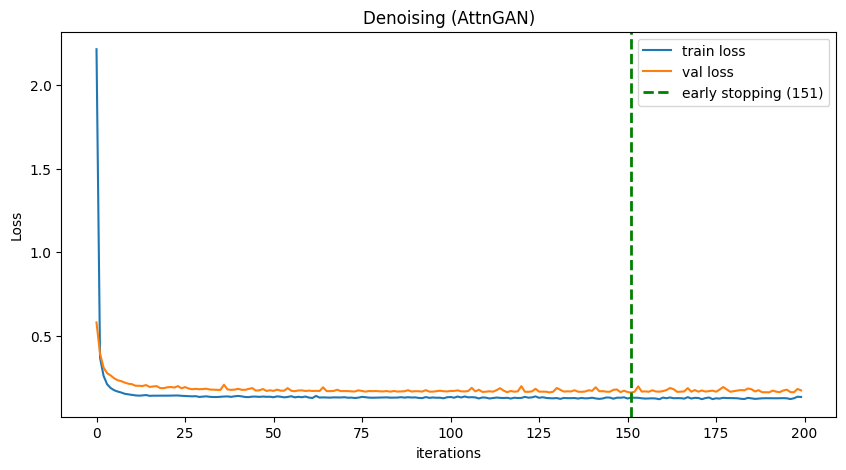

In [12]:
plt.figure(figsize=(10,5))
plt.title("Denoising (AttnGAN)")
plt.plot(train_g_losses,label="train loss")
plt.plot(valid_g_losses,label="val loss")
plt.axvline(best_epoch, color='green', linestyle='--', linewidth=2, label=f"early stopping ({best_epoch})")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()